# Import Libraries

In [3]:
import pandas as pd 
import random
import numpy as np

import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

# Load Dataset

In [4]:
PROTEINS_A = pd.read_csv("./Datasets/proteins/PROTEINS_A.txt", header = None)
PROTEINS_graph_indicator = pd.read_csv("./Datasets/proteins/PROTEINS_graph_indicator.txt", header = None)
PROTEINS_graph_labels = pd.read_csv("./Datasets/proteins/PROTEINS_graph_labels.txt", header = None)
PROTEINS_node_attributes = pd.read_csv("./Datasets/proteins/PROTEINS_node_attributes.txt", header = None)
print(PROTEINS_graph_labels.shape)
print(PROTEINS_node_attributes.shape)
print(PROTEINS_graph_indicator.shape)
print(PROTEINS_A.shape)

(1113, 1)
(43471, 1)
(43471, 1)
(162088, 2)


In [5]:
PROTEINS_graph_labels = PROTEINS_graph_labels -1
PROTEINS_A = PROTEINS_A - 1

In [6]:
Dataset = []

for i in PROTEINS_graph_indicator[0].unique():
    nodes_index = PROTEINS_graph_indicator.loc[PROTEINS_graph_indicator[0] == i].index
    nodes_attributes = PROTEINS_node_attributes.loc[nodes_index]
    x = torch.tensor(nodes_attributes.values)
    edge = PROTEINS_A.loc[PROTEINS_A[0].isin(nodes_index)] -PROTEINS_A.loc[PROTEINS_A[0].isin(nodes_index)].min().min()
    edge = edge.values.T
    y = PROTEINS_graph_labels.iloc[i-1]
    
    G1= Data(x=torch.tensor(x,dtype=torch.float),edge_index=torch.tensor(edge,dtype=torch.long),y=torch.tensor(y))
    Dataset.append(G1)   


C:\Windows\TEMP/ipykernel_24516/2023682678.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  G1= Data(x=torch.tensor(x,dtype=torch.float),edge_index=torch.tensor(edge,dtype=torch.long),y=torch.tensor(y))


In [7]:
random.shuffle(Dataset)
print(len(Dataset))

1113


In [8]:
train_size = int(np.ceil(len(Dataset) *0.6))
val_size = int(np.ceil(len(Dataset) *0.2))
test_size = len(Dataset) - train_size - val_size

In [9]:
train_dataset = Dataset[:train_size]
val_dataset = Dataset[train_size:train_size+val_size]
test_dataset = Dataset[train_size+val_size:]

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[2295, 1], edge_index=[2, 8922], y=[64], batch=[2295], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[2473, 1], edge_index=[2, 9436], y=[64], batch=[2473], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[2305, 1], edge_index=[2, 8710], y=[64], batch=[2305], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[2801, 1], edge_index=[2, 9890], y=[64], batch=[2801], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[2078, 1], edge_index=[2, 7972], y=[64], batch=[2078], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[3543, 1], edge_index=[2, 12894], y=[64], batch=[3543], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[3024, 1], edge_index=[2, 11812], y=[64], batch=[3024], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(x=[2444, 1], edge_index=[2, 9110], y=[64],

# Define Model

In [26]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(Dataset[0].num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, int(hidden_channels/2))
        self.lin = Linear(int(hidden_channels/2), 2)

    def forward(self, x, edge_index, batch):
        # Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        
        # Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


# Training 

In [49]:
def train(epochs, train_loader,val_loader, loss_func,optimizer, learning_rate):
    criterion = loss_func()
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    model.train()
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    for epoch in range(epochs):
        correct = 0 
        loss_sum = 0
        for data in train_loader:  # Iterate in batches over the training dataset.
            out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
            loss = criterion(out, data.y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.
            loss_sum +=loss

        acc_train = correct / len(train_loader.dataset)  
        loss_train = loss_sum / len(train_loader)  
        
        correct = 0 
        loss_sum = 0
        for data in val_loader:  # Iterate in batches over the training dataset.
            out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
            loss = criterion(out, data.y)  # Compute the loss.
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.
            loss_sum +=loss

        acc_val = correct / len(val_loader.dataset)  
        loss_val = loss_sum / len(val_loader)  
        
        train_loss.append(loss_train.detach())
        train_acc.append(acc_train)
        val_loss.append(loss_val.detach())
        val_acc.append(acc_val)
#        print(f'Epoch: {epoch:03d}, Train Acc: {acc_train:.4f}, Train loss: {loss_train:.4f}')

        print(f'Epoch: {epoch:03d}, Train Acc: {acc_train:.4f}, Train loss: {loss_train:.4f}, Val Acc: {acc_val:.4f}, Val loss: {loss_val:.4f}')
        
    return train_loss, train_acc, val_loss, val_acc

In [60]:
model = GCN(hidden_channels=256)
print(model)
loss_func = torch.nn.CrossEntropyLoss
optimizer = torch.optim.SGD
epochs = 10
learning_rate = 0.001
train_loss, train_acc, val_loss, val_acc = train(epochs, train_loader,val_loader, loss_func,optimizer, learning_rate)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 128)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)
Epoch: 000, Train Acc: 0.4641, Train loss: 0.7121, Val Acc: 0.4619, Val loss: 0.7086
Epoch: 001, Train Acc: 0.4865, Train loss: 0.6990, Val Acc: 0.4350, Val loss: 0.7082
Epoch: 002, Train Acc: 0.4865, Train loss: 0.6953, Val Acc: 0.5381, Val loss: 0.6928
Epoch: 003, Train Acc: 0.5105, Train loss: 0.6971, Val Acc: 0.5247, Val loss: 0.6980
Epoch: 004, Train Acc: 0.5195, Train loss: 0.6962, Val Acc: 0.5740, Val loss: 0.6900
Epoch: 005, Train Acc: 0.5599, Train loss: 0.6882, Val Acc: 0.5471, Val loss: 0.6938
Epoch: 006, Train Acc: 0.5838, Train loss: 0.6829, Val Acc: 0.5695, Val loss: 0.6884
Epoch: 007, Train Acc: 0.5719, Train loss: 0.6880, Val Acc: 0.5740, Val loss: 0.6808
Epoch: 008, Train Acc: 0.5749, Train loss: 0.6799, Val Acc: 0.5830, Val loss: 0.6926
Epoch: 009, Train Acc: 0.5943, Train loss: 0.6802, Val Acc: 0.5785, Val loss: 0.686

# save Model

In [61]:
path = './saved_models/task2/task2.pt'
torch.save(model.state_dict(), path)

np.save('./saved_models/task2/train_loss', train_loss)
np.save('./saved_models/task2/val_loss', val_loss)
np.save('./saved_models/task2/train_acc', train_acc)
np.save('./saved_models/task2/val_acc', val_acc)

# Testing

In [62]:
def test(test_loader, loss_func):
    criterion = loss_func()
    correct =0
    loss_sum =0
    best = 0
    worst = 10
    for data in test_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        prob, _ = out.max(dim=1)
        best_pred = prob.max()
        worst_pred = prob.min()
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        loss_sum +=loss
        if best_pred>best:
            best = best_pred
        if worst_pred<worst:
            worst = worst_pred
        
    acc_test = correct / len(test_loader.dataset)  
    loss_test = loss_sum / len(test_loader)
        
    print(f'Test accuracy: {acc_test:.4f}, Test loss: {loss_test:.4f}')
    print('best pred: ', best_pred)
    print('worst pred: ', worst_pred)

In [63]:
path = './saved_models/task2/task2.pt'
model = GCN(hidden_channels=256)
model.load_state_dict(torch.load(path))
loss_func = torch.nn.CrossEntropyLoss
test(test_loader, loss_func)

Test accuracy: 0.5631, Test loss: 0.7116
best pred:  tensor(1.2012, grad_fn=<MaxBackward1>)
worst pred:  tensor(0.0523, grad_fn=<MinBackward1>)


# Visualization

val loss: 0.67925453
train loss: 0.6841047


Text(0.5, 1.0, 'training and validation loss')

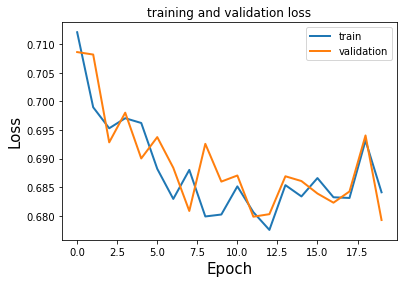

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

train_loss = np.load('./saved_models/task2/train_loss.npy')
val_loss = np.load('./saved_models/task2/val_loss.npy')
print('val loss:', val_loss[-1])
print('train loss:', train_loss[-1])
plt.plot(train_loss, linewidth=2, label='train')
plt.plot(val_loss, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.title('training and validation loss')

val accuracy: 0.6053811659192825
train accuracy: 0.5898203592814372


Text(0.5, 1.0, 'training and validation Accuracy')

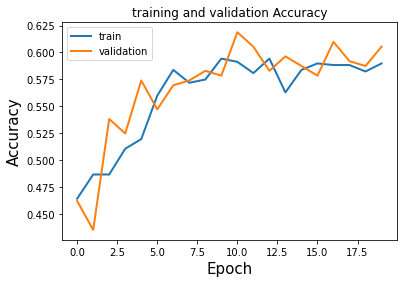

In [57]:
val_acc = np.load('./saved_models/task2/val_acc.npy')
train_acc = np.load('./saved_models/task2/train_acc.npy')
print('val accuracy:', val_acc[-1])
print('train accuracy:', train_acc[-1])
plt.plot(train_acc, linewidth=2, label='train')
plt.plot(val_acc, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title('training and validation Accuracy')